# Krafthack March 7-8 2022
**Team: Data Liberators**  
- Andris Piebalgs
- Hayden Hohns
- Simon Stavland

Requirements:
* Install all required packages with poetry `poetry install`
* All data must be store locally in parent folder under `data`

Summary:
* Import and preprocess data for machine learning
* Train a machine learning model to predict the strain on 6 different bolts
* 2 regression models have been considered: Linear and Random Forest Regression.
* Good MAPE (Mean Absolute Error Percentage) score for non-linear model with graphical validation

# Importing python libraries

In [1]:
import os
import time

from dataclasses import dataclass
from functools import wraps
from typing import Any, Callable

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

%matplotlib inline

In [4]:
pd.DataFrame(index=pd.date_range(start='2023', end='2050',freq='1M'))

""
2023-01-31
2023-02-28
2023-03-31
2023-04-30
2023-05-31
...
2049-08-31
2049-09-30
2049-10-31
2049-11-30


## Loading dataset

In [56]:
# datasets are stored in the data folder
data_dir = os.path.join("..","data")
#dataset_1 = os.path.join(data_dir,"input_dataset-1.parquet")
dataset_2 = os.path.join(data_dir,"input_dataset-2.parquet")
bolt_pretension_file = os.path.join("bolt_pretension.csv")
prediction_input_file = os.path.join(data_dir,"prediction_input.parquet")

# validation data
validation_raw = pd.read_parquet(prediction_input_file)
#training_data_1 = pd.read_parquet(dataset_1)
training_data_2 = pd.read_parquet(dataset_2)

# features are found from the validation set
feature_names = list(validation_raw.columns)

# dataset 2 contains the training data:
x_raw = training_data_2[feature_names]
target_vars = training_data_2.filter(regex="Tensile")


# Preprocessing and feature engineering

In [76]:
# functions for preprocessing pipeline

def log_df_pipe(f: Callable):
    """
    Decorator for logging functions handling dataframes
    Can be applied to functions where a dataframe is the input and output
    Typically functions used with df.pipe(f, *args)
    """
    @wraps(f)
    def wrapper(df, *args, **kwargs):
        start = time.time()
        result = f(df, *args, **kwargs)
        elapsed_time = time.time() - start
        print(f"{f.__name__} took {elapsed_time} seconds")
        print(f"Dataframe shape: {result.shape}")
        print(f"NA in dataframe: {result.isna().sum().sum()}")
        return result

    return wrapper

@log_df_pipe
def copy_df(df:pd.DataFrame):
    return df.copy()

@log_df_pipe
def mode_to_numerical(df: pd.DataFrame):
    df.loc[:, "mode"] = (df["mode"]=="operation").astype(float)
    return df

@log_df_pipe
def drop_na(df: pd.DataFrame):
    return df.dropna(axis=0)


@log_df_pipe
def add_seasonality_features(df: pd.DataFrame) -> pd.DataFrame:
    """Perform pre-processing of data.

    Args:
        df (pd.DataFrame): Dataframe that contains a valid index (datetime).

    Returns:
        pd.DataFrame: Same input dataframe but with extra columns.
    """
    #df["month"] = df.index.month
    #df["day"] = df.index.day
    # heavy rain: september-november, snow: december-march, melting: april-june, dry: july-august
    # Snow = 1, Melting = 2, Dry = 3, Rain = 4
    seasons = {
        1: 1, 2: 1, 3: 1, 
        4: 2, 5: 2, 6: 2,
        7: 3, 8: 3,
        9: 4, 10: 4, 11: 4,
        12: 1
    }
    df["season"] = df.index.month.map(seasons)
    df["time"] = [item.value/1e9 for item in df.index]
    return df

In [77]:
x = (
    x_raw.pipe(copy_df)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(drop_na)
)

validation = (
    validation_raw.pipe(copy_df)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(drop_na)
)

copy_df took 0.022304296493530273 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
mode_to_numerical took 0.0993654727935791 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
add_seasonality_features took 5.189898252487183 seconds
Dataframe shape: (1874087, 9)
NA in dataframe: 744522
drop_na took 0.28384900093078613 seconds
Dataframe shape: (1750000, 9)
NA in dataframe: 0
copy_df took 0.00241851806640625 seconds
Dataframe shape: (226364, 7)
NA in dataframe: 0
mode_to_numerical took 0.01383352279663086 seconds
Dataframe shape: (226364, 7)
NA in dataframe: 0
add_seasonality_features took 0.5951485633850098 seconds
Dataframe shape: (226364, 9)
NA in dataframe: 0
drop_na took 0.0075969696044921875 seconds
Dataframe shape: (226364, 9)
NA in dataframe: 0


### Ensure that nans are removed for target variables too

In [78]:
# Drop nans in target data
def drop_target_nans(targets_df, train_raw_df):
    is_nan_row = train_raw_df.isna().any(axis=1)
    targets_df = targets_df[~is_nan_row]
    return targets_df

In [79]:
targets_df = (
    target_vars.pipe(copy_df)
    .pipe(drop_target_nans, x_raw )
)

copy_df took 0.0938260555267334 seconds
Dataframe shape: (1874087, 6)
NA in dataframe: 744522


In [80]:
assert targets_df.shape[0] == x.shape[0]

# Build ML model

In [81]:
# container for model response
@dataclass
class ModelResponse:
    bolt_name: str
    model: Any
    scaler: Any
    train_mape: float
    test_mape: float
    y_test: Any
    y_pred: Any

In [82]:
def train_bolts_models(train_df, targets_df, model=LinearRegression()):
    
    res = {}
    
    # Iterate through each target (i.e. each bolt)
    for target_name, target_data in targets_df.iteritems():
        
        print(f"Started training {target_name}")
        
        X_train, X_test = np.split(train_df, [int(.4 *len(train_df))])
        y_train, y_test = np.split(target_data, [int(.4 *len(target_data))])
        
        # Create cross validation pipeline
        scoring = {'mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error)}
        scaler = StandardScaler()
        pipe = Pipeline([('scaler', scaler), ('clf', model)])
        pipe.fit(X_train, y_train)
        
        # Get the mean scores for test and training
        y_pred_test = pipe.predict(X_test)
        train_mape = mean_absolute_percentage_error(y_train, pipe.predict(X_train))
        test_mape = mean_absolute_percentage_error(y_test,y_pred_test)
                
        # save to output dict
        res[target_name] = ModelResponse(bolt_name=target_name, model = model, scaler=scaler, train_mape=train_mape, test_mape=test_mape, y_test=y_test, y_pred=y_pred_test)

        print(f"Finished training {target_name}")
    return res

In [83]:
def plot_results(model_res):
    fig, axs = plt.subplots(6, figsize=(15, 30))
    for i, model_response in enumerate(model_res.values()):
        y_test = model_response.y_test
        y_pred = model_response.y_pred
        axs[i].plot(range(1400,1800), range(1400, 1800))
        axs[i].plot(y_test, y_pred, "o")
        axs[i].set_title(model_response.bolt_name)
        axs[i].set(xlabel="y_test", ylabel="y_pred")

# Baseline model

Using Linear Regression as baseline for model performance.

In [84]:
linear_res = train_bolts_models(x, targets_df)

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [85]:
for response in linear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.00012798361977686833, test mape: 0.0015721246239864784
train mape: 0.00010352479862371725, test mape: 0.0011461452144545569
train mape: 8.864293442671763e-05, test mape: 0.0021485841680481507
train mape: 9.432404210613557e-05, test mape: 0.0015768030709414852
train mape: 8.718238215038591e-05, test mape: 0.0009038230857404035
train mape: 0.00011292066666172106, test mape: 0.002986479244955262


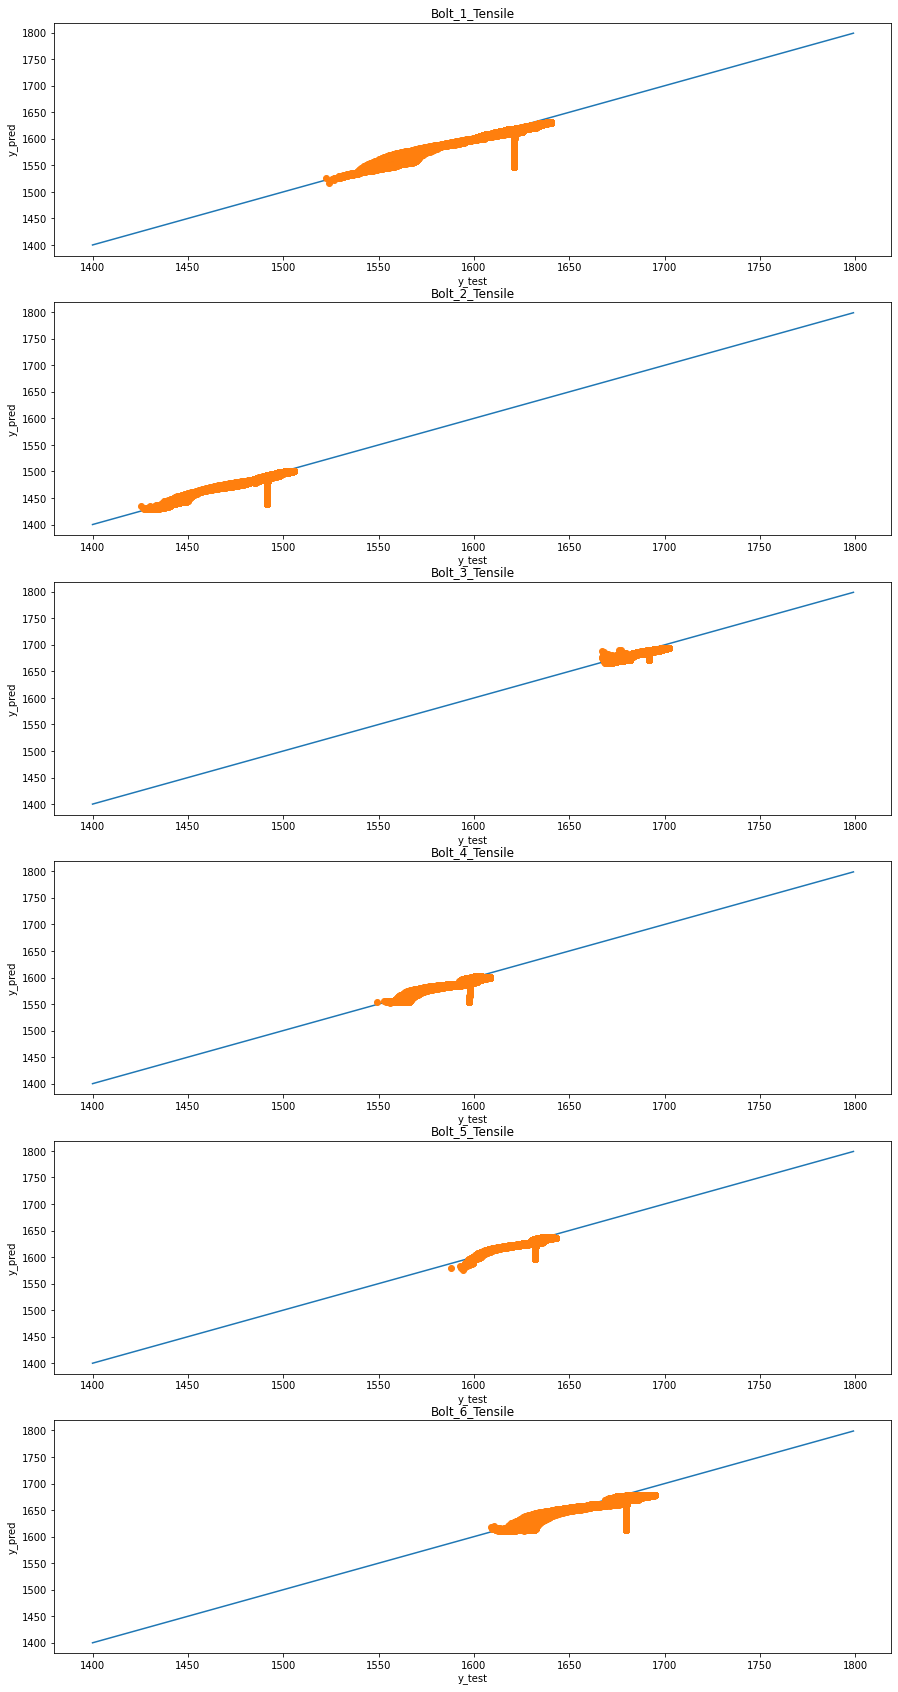

In [86]:
plot_results(linear_res)

# ML Model

Training with nonlinear RandomForestRegressor. 

In [87]:
from time import time

start_time = time()
nonlinear_res = train_bolts_models(x, targets_df, model=RandomForestRegressor(n_estimators=10))

print((time()-start_time)/60)

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile
7.213173786799113


In [88]:
for response in nonlinear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 2.5994440969288495e-06, test mape: 0.008189649027203079
train mape: 2.8784299200608237e-06, test mape: 0.005483532097109237
train mape: 1.7567306729659832e-06, test mape: 0.003868108058178457
train mape: 2.1693066558405106e-06, test mape: 0.0008067580787984181
train mape: 2.5829440850865465e-06, test mape: 0.0008092713475376536
train mape: 3.774794040899958e-06, test mape: 0.0034137024797383634


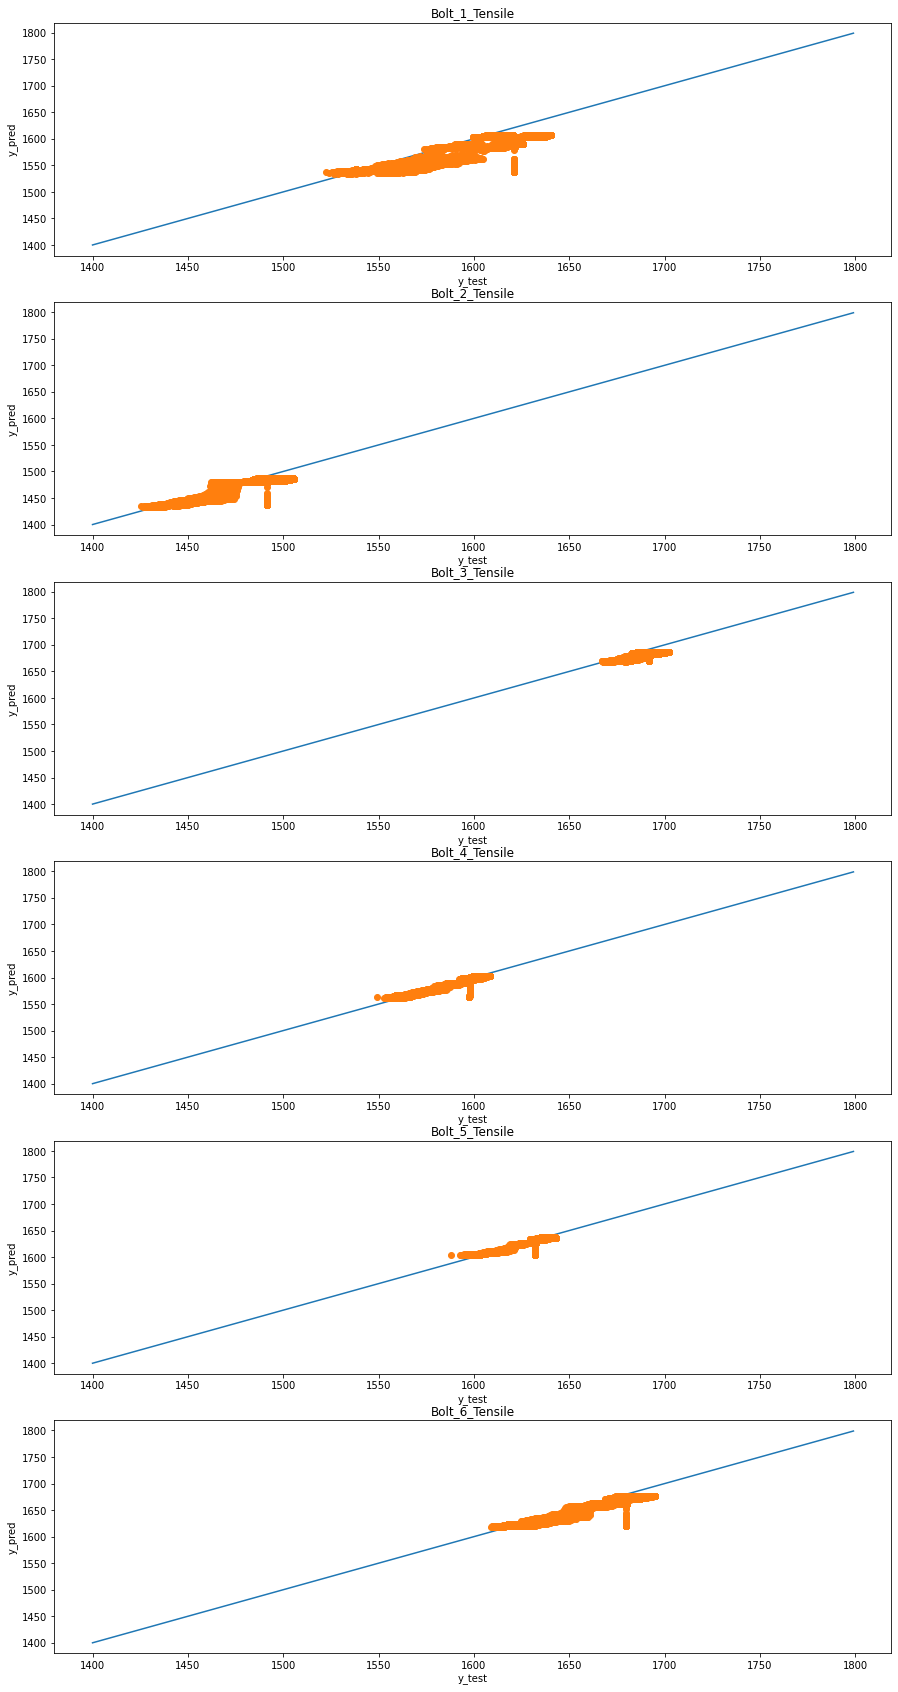

In [89]:
plot_results(nonlinear_res)

# Export csv file with predictions

We take best model and do a fit on the entire dataset. We then use the input data set to generate predictions.

In [90]:
#model = LinearRegression()
model = RandomForestRegressor(n_estimators=10)

store=[]
for target_name, target_data in targets_df.iteritems():
    
    print(f'Training {target_name}...')
    
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler), ('clf', model)])
    pipe.fit(x, target_data)
    y_pred = pipe.predict(validation)
    
    res = pd.Series(y_pred, index=validation.index, name=target_name)
    store.append(res)

    
predictions_df = pd.concat(store,axis=1)

csv_export_filename = "bolt_tensile_predictions.csv"
predictions_df.to_csv(csv_export_filename)

Training Bolt_1_Tensile...
Training Bolt_2_Tensile...
Training Bolt_3_Tensile...
Training Bolt_4_Tensile...
Training Bolt_5_Tensile...


KeyboardInterrupt: 